In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import time
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import multiprocessing

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    
    return tf.argmax(tf.cast(one_hot, tf.int32))

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_TL(file_path):
    label = get_label(file_path)
    print(label)
    img = tf.io.read_file(file_path)

    img = decode_img(img)
    #img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, label

Num GPUs Available:  1


In [2]:
img_height = 224
img_width = 224

base_dir = r'C:\Users\Szymon\101_split'
train_dir = base_dir + '\\train'
val_dir = base_dir + '\\val'

train_files = tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=False)
val_files = tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False)

train_num_files=len([file for file in glob(str(train_dir + '\\*\\*'))])
val_num_files=len([file for file in glob(str(val_dir + '\\*\\*'))])
print(train_num_files)
print(val_num_files)

class_names = np.array(sorted([dir1 for dir1 in os.listdir(train_dir)]))
num_classes = len(class_names)

train_dataset = train_files.interleave(lambda x: tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=True), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_files.interleave(lambda x: tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)

5724
821
Tensor("ArgMax:0", shape=(), dtype=int64)
Tensor("ArgMax:0", shape=(), dtype=int64)


In [3]:
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.1),
    ])

base_model = tf.keras.models.load_model('own_intel.h5')
base_model.pop()

#base_model.trainable = False

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    #data_augmentation,
    base_model,
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 512)               2044512   
_________________________________________________________________
dense (Dense)                (None, 97)                49761     
Total params: 2,094,273
Trainable params: 2,091,681
Non-trainable params: 2,592
_________________________________________________________________


In [4]:
epoch = 25
batch_size = 16

train_dataset = train_dataset.repeat().shuffle(buffer_size=32).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
train_dataset =train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset =val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

start_time= time.perf_counter()
model_train = model.fit(
    train_dataset,
    steps_per_epoch = int((train_num_files)/batch_size),
    validation_data = val_dataset,
    validation_steps = int(val_num_files/batch_size),
    epochs=epoch)

print(time.perf_counter()-start_time)

Epoch 1/25
357/357 [==============================] - 63s 156ms/step - loss: 3.5682 - accuracy: 0.2507 - val_loss: 2.5541 - val_accuracy: 0.4461
Epoch 2/25
357/357 [==============================] - 55s 153ms/step - loss: 2.8968 - accuracy: 0.3528 - val_loss: 2.7889 - val_accuracy: 0.3627
Epoch 3/25
357/357 [==============================] - 53s 149ms/step - loss: 2.6434 - accuracy: 0.3972 - val_loss: 2.1795 - val_accuracy: 0.4804
Epoch 4/25
357/357 [==============================] - 55s 154ms/step - loss: 2.3942 - accuracy: 0.4373 - val_loss: 2.3397 - val_accuracy: 0.4657
Epoch 5/25
357/357 [==============================] - 54s 150ms/step - loss: 2.2063 - accuracy: 0.4757 - val_loss: 2.1957 - val_accuracy: 0.4510
Epoch 6/25
357/357 [==============================] - 54s 152ms/step - loss: 2.1199 - accuracy: 0.4820 - val_loss: 1.9364 - val_accuracy: 0.5490
Epoch 7/25
357/357 [==============================] - 54s 152ms/step - loss: 2.0201 - accuracy: 0.5109 - val_loss: 1.8410 - val_ac

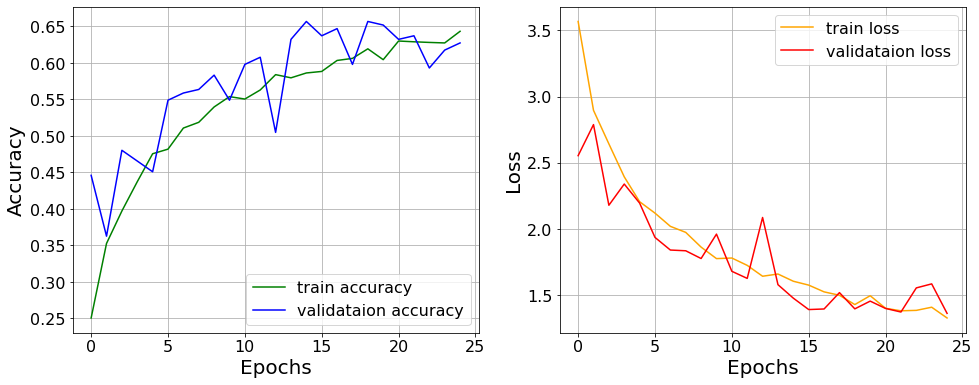

In [5]:
train_loss = model_train.history['loss']
train_acc = model_train.history['accuracy']
valid_loss = model_train.history['val_loss']
valid_acc = model_train.history['val_accuracy']

plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='validataion accuracy')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()


plt.subplot(1,2,2)
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.savefig('results.png')

In [4]:
for layer in model.layers:
    layer.trainable = True

epoch = 25
batch_size = 16

start_time2 = time.perf_counter()
model_finetune = model.fit(
    train_dataset,
    steps_per_epoch = int((train_num_files)/batch_size),
    validation_data = val_dataset,
    validation_steps = int(val_num_files/batch_size),
    epochs=epoch)

print(time.perf_counter()-start_time2)

Epoch 1/25


ValueError: in user code:

    D:\Programy\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:862 train_function  *
        return step_function(self, iterator)
    D:\Programy\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:852 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    D:\Programy\Anaconda\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    D:\Programy\Anaconda\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    D:\Programy\Anaconda\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    D:\Programy\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:845 run_step  **
        outputs = model.train_step(data)
    D:\Programy\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:802 train_step
        y_pred = self(x, training=True)
    D:\Programy\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1040 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    D:\Programy\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:215 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (224, 224, 3)


In [ ]:
train_loss = model_finetune.history['loss']
train_acc = model_finetune.history['accuracy']
valid_loss = model_finetune.history['val_loss']
valid_acc = model_finetune.history['val_accuracy']

plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='validataion accuracy')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()


plt.subplot(1,2,2)
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()